In [9]:
!pip install gensim --upgrade
!pip install pandas --upgrade
!pip install keras==2.6

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 25.2 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: gensim
    Found existing installation: gensim 4.0.1
    Uninstalling gensim-4.0.1:
      Successfully uninstalled gensim-4.0.1


In [10]:
#basics libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

#keras
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools


In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [7]:
!pip install xlrd

In [13]:
!pip install openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.1/242.1 kB 1.6 MB/s eta 0:00:00a 0:00:01


In [14]:
df = pd.read_excel("/kaggle/input/twittersentiment-data/Tweet Sentimental Data.xlsx")

In [15]:
df.head(5)

,TARGET,ID,Date,FLAG,USER,TEXT-DATA
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [24]:
df.columns

Index(['TARGET', 'ID', 'Date', 'FLAG', 'USER', 'TEXT-DATA'], dtype='object')

In [16]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [19]:
%%time
df.TARGET = df.TARGET.apply(lambda x: decode_sentiment(x))

CPU times: user 2.33 ms, sys: 0 ns, total: 2.33 ms
Wall time: 2.22 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

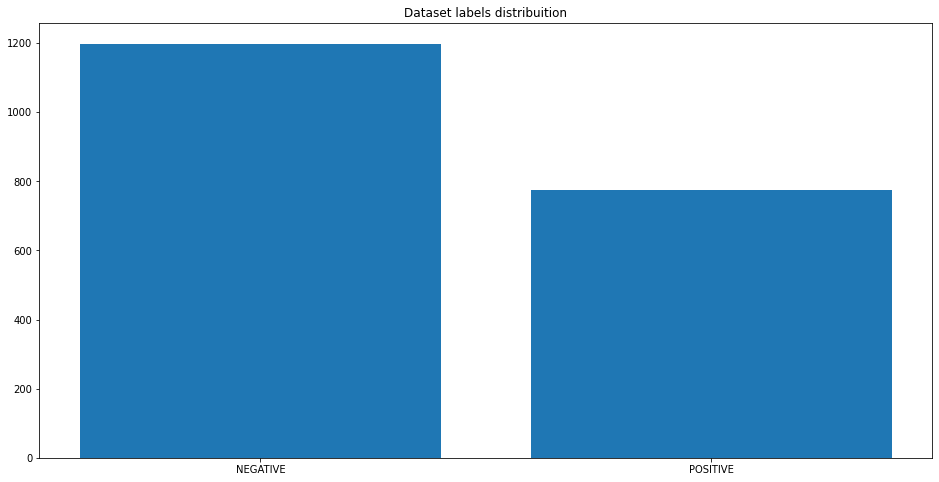

In [20]:
target_cnt = Counter(df.TARGET)
plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [21]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [22]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [27]:
%%time
df['TEXT-DATA'] = df['TEXT-DATA'].apply(lambda x: preprocess(x))

CPU times: user 93.6 ms, sys: 1.99 ms, total: 95.6 ms
Wall time: 94.2 ms


**Split train and test**

In [28]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1579
TEST size: 395


**Word-2-Vec**

In [32]:
%%time
documents = [_text.split() for _text in df_train['TEXT-DATA']]

CPU times: user 2.12 ms, sys: 14 µs, total: 2.14 ms
Wall time: 2.27 ms


In [34]:
import multiprocessing
from gensim.models import Word2Vec

In [35]:
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [36]:
w2v_model.build_vocab(documents)

In [37]:
words = w2v_model.wv.key_to_index.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 202


In [38]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

CPU times: user 390 ms, sys: 48.3 ms, total: 438 ms
Wall time: 390 ms


(91811, 364064)

In [70]:
w2v_model.wv.most_similar("hate")

[('man', 0.9993597865104675),
 ('yet', 0.9993109107017517),
 ('miss', 0.999305248260498),
 ('lol', 0.9992890357971191),
 ('3', 0.9992827773094177),
 ('getting', 0.9992520213127136),
 ('sick', 0.9992432594299316),
 ('thats', 0.9992255568504333),
 ('school', 0.9992204308509827),
 ('much', 0.9992185831069946)]

In [41]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train['TEXT-DATA'])

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 4127
CPU times: user 33.7 ms, sys: 740 µs, total: 34.4 ms
Wall time: 32.9 ms


In [42]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train['TEXT-DATA']), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test['TEXT-DATA']), maxlen=SEQUENCE_LENGTH)

CPU times: user 35.8 ms, sys: 979 µs, total: 36.8 ms
Wall time: 35.4 ms


In [44]:
labels = df_train.TARGET.unique().tolist()
labels.append(NEUTRAL)
labels

['NEGATIVE', 'POSITIVE', 'NEUTRAL']

In [45]:
encoder = LabelEncoder()
encoder.fit(df_train.TARGET.tolist())

y_train = encoder.transform(df_train.TARGET.tolist())
y_test = encoder.transform(df_test.TARGET.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1579, 1)
y_test (395, 1)


In [46]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1579, 300)
y_train (1579, 1)

x_test (395, 300)
y_test (395, 1)


In [47]:
y_train[:10]

array([[0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0]])

In [48]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(4127, 300)


In [49]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [55]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(200, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          1238100   
_________________________________________________________________
dropout_2 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 200)               400800    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 1,639,101
Trainable params: 401,001
Non-trainable params: 1,238,100
_________________________________________________________________


In [56]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [57]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [58]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8
2/2 [==============================] - 25s 8s/step - loss: 0.6901 - accuracy: 0.5081 - val_loss: 0.6607 - val_accuracy: 0.6582
Epoch 2/8
2/2 [==============================] - 20s 7s/step - loss: 0.6787 - accuracy: 0.6052 - val_loss: 0.6544 - val_accuracy: 0.6582
Epoch 3/8
2/2 [==============================] - 21s 7s/step - loss: 0.6798 - accuracy: 0.6052 - val_loss: 0.6550 - val_accuracy: 0.6582
Epoch 4/8
2/2 [==============================] - 21s 8s/step - loss: 0.6778 - accuracy: 0.6052 - val_loss: 0.6586 - val_accuracy: 0.6582
Epoch 5/8
2/2 [==============================] - 20s 7s/step - loss: 0.6761 - accuracy: 0.6052 - val_loss: 0.6599 - val_accuracy: 0.6582
Epoch 6/8
2/2 [==============================] - 20s 7s/step - loss: 0.6750 - accuracy: 0.6052 - val_loss: 0.6594 - val_accuracy: 0.6582
Epoch 7/8
2/2 [==============================] - 21s 8s/step - loss: 0.6754 - accuracy: 0.6052 - val_loss: 0.6581 - val_accuracy: 0.6582
Epoch 8/8
2/2 [==========================

In [59]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

1/1 [==============================] - 1s 1s/step - loss: 0.6726 - accuracy: 0.5924

ACCURACY: 0.5924050807952881
LOSS: 0.6725848913192749
CPU times: user 3.91 s, sys: 242 ms, total: 4.16 s
Wall time: 1.41 s


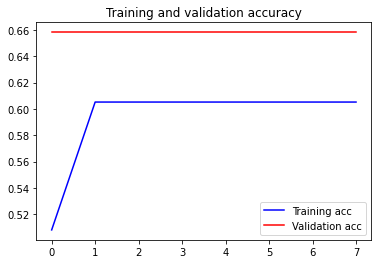

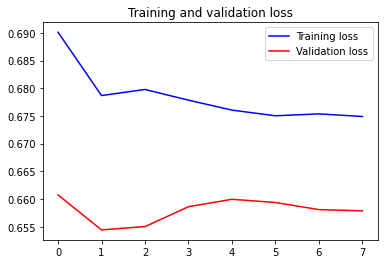

In [60]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [61]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [62]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [69]:
predict("I am a human being")

{'label': 'NEUTRAL',
 'score': 0.4709876775741577,
 'elapsed_time': 0.32065582275390625}

In [68]:
predict("I hate the rain")

{'label': 'NEUTRAL',
 'score': 0.4414624869823456,
 'elapsed_time': 0.3297262191772461}

In [72]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.TARGET)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

1/1 [==============================] - 2s 2s/step
CPU times: user 4.15 s, sys: 245 ms, total: 4.39 s
Wall time: 1.68 s


In [75]:
#Classification Report
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.59      1.00      0.74       234
    POSITIVE       0.00      0.00      0.00       161

    accuracy                           0.59       395
   macro avg       0.30      0.50      0.37       395
weighted avg       0.35      0.59      0.44       395



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [74]:
#Accuracy Score
accuracy_score(y_test_1d, y_pred_1d)

0.5924050632911393